In [9]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

# Compute the camera calibration matrix 

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. 




Provide an example of a distortion corrected calibration image.

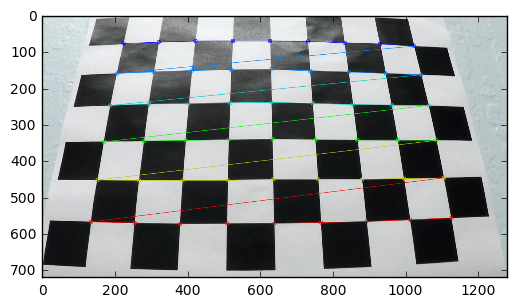

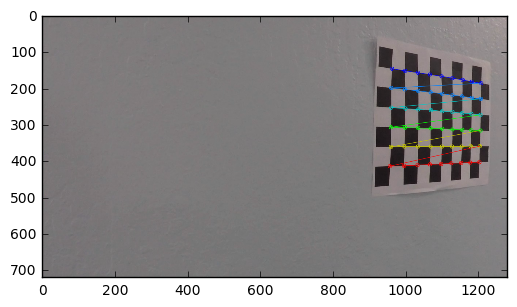

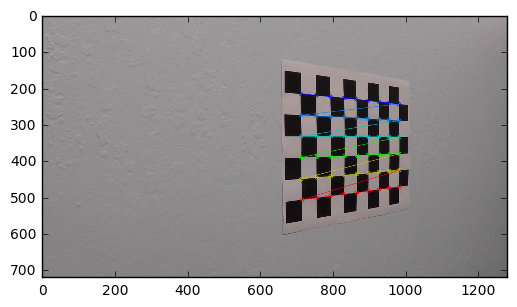

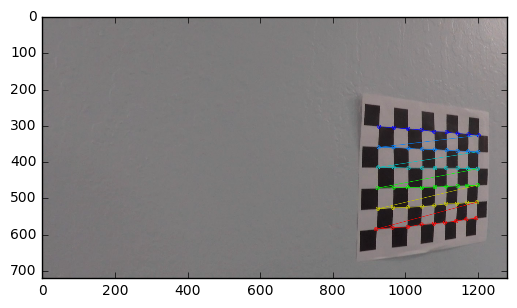

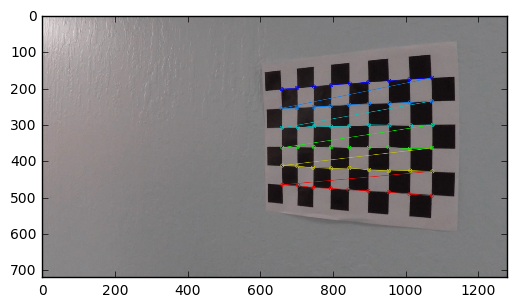

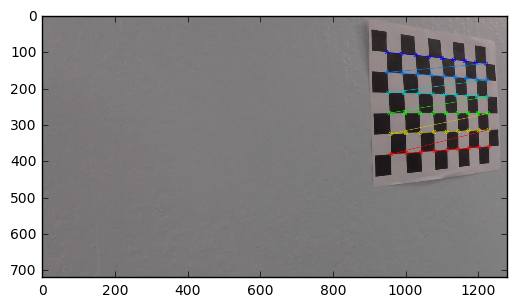

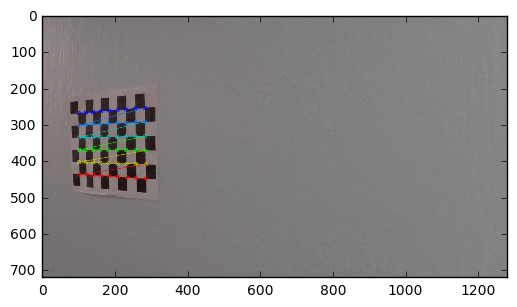

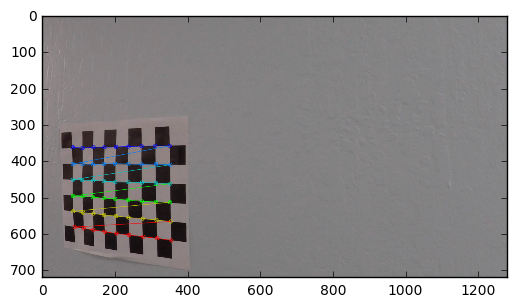

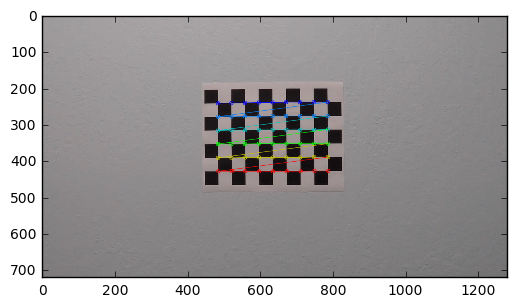

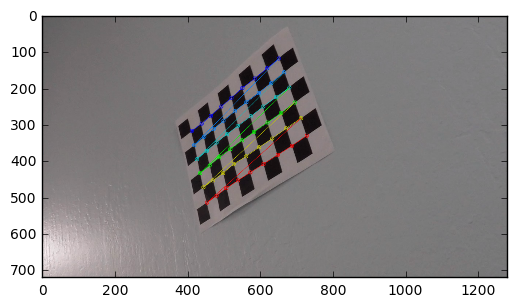

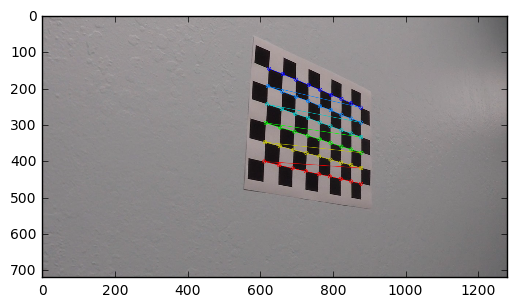

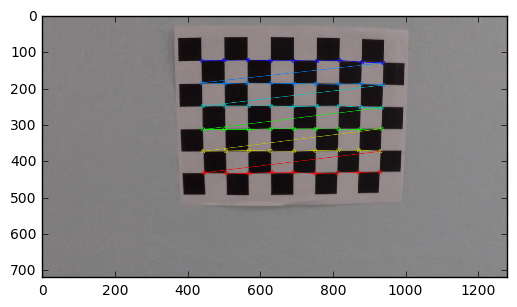

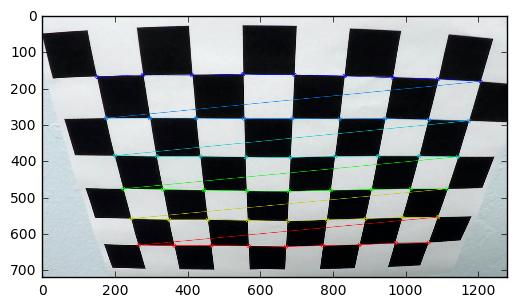

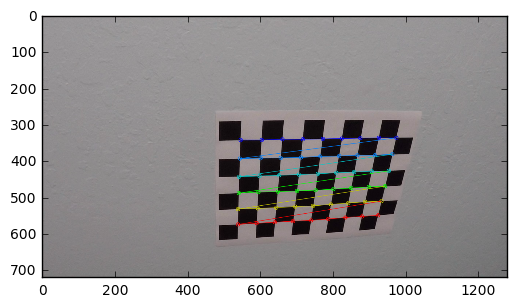

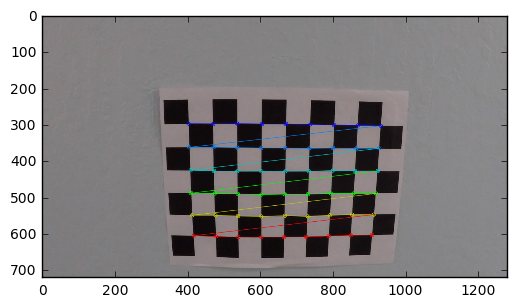

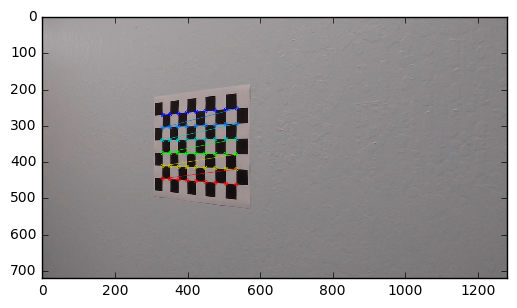

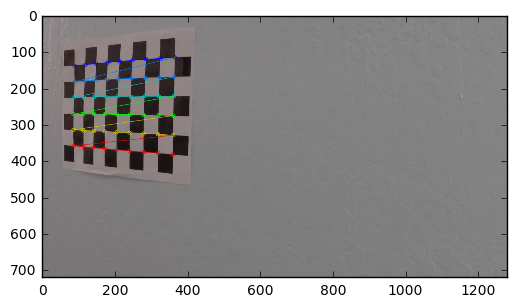

In [10]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()
        

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist



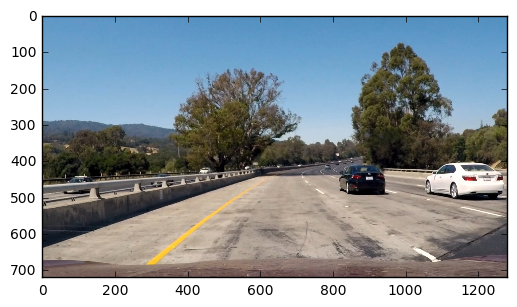

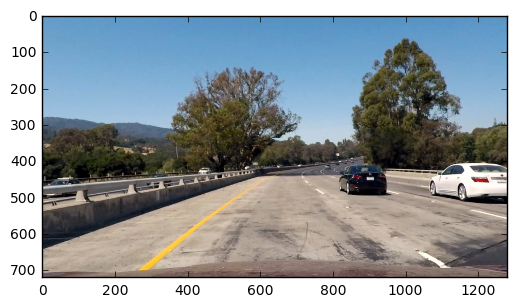

In [11]:
example_image = plt.imread('./test_images/test1.jpg')
plt.imshow(example_image)
plt.show()
img_undist = cal_undistort(example_image, objpoints, imgpoints)
plt.imshow(img_undist)
plt.show()

#### 2. Creating a thresholded binary image.

In [109]:
class WidgetCom:
    value = dict()
WidgetCom.value['mutex'] = False
WidgetCom.value['S_chan_min_param'] = 70
WidgetCom.value['V_chan_min_param'] = 220
WidgetCom.value['gray_min_param'] = 205
WidgetCom.value['sobel_angle_min'] = -180.0
WidgetCom.value['sobel_angle_max'] = 180.0
WidgetCom.value['sobel_mag'] = 2.0

In [110]:
# http://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html
# Using widget to help calibrating computer vision parameters
    
def handle_slider1_change(change):
    WidgetCom.value['S_chan_min_param'] = change.new
    display_image()
    
def handle_slider2_change(change):
    WidgetCom.value['V_chan_min_param'] = change.new
    display_image()
    
def handle_slider3_change(change):
    WidgetCom.value['gray_min_param'] = change.new
    display_image()
    
def handle_slider4_change(change):
    WidgetCom.value['sobel_thresh_min'] = change.new
    display_image()
    
def handle_slider5_change(change):
    WidgetCom.value['sobel_thresh_max'] = change.new
    display_image()
    
def handle_slider6_change(change):
    WidgetCom.value['sobel_mag'] = change.new
    display_image()
    
from ipywidgets import widgets
slider1 = widgets.IntSlider(min=0, max=255, value=WidgetCom.value['S_chan_min_param'], description='S chan')
slider2 = widgets.IntSlider(min=0, max=255, value=WidgetCom.value['V_chan_min_param'], description='V chan')
slider3 = widgets.IntSlider(min=0, max=255, value=WidgetCom.value['gray_min_param'], description='gray')
slider4 = widgets.FloatSlider(min=-180, max=180, value=WidgetCom.value['sobel_angle_min'], description='sobel_angle_min')
slider5 = widgets.FloatSlider(min=-180, max=180, value=WidgetCom.value['sobel_angle_max'], description='sobel_angle_max')
slider6 = widgets.FloatSlider(min=0, max=180, value=WidgetCom.value['sobel_mag'], description='sobel_mag')

slider1.observe(handle_slider1_change, names='value')
slider2.observe(handle_slider2_change, names='value')
slider3.observe(handle_slider3_change, names='value')
slider4.observe(handle_slider4_change, names='value')
slider5.observe(handle_slider5_change, names='value')
slider6.observe(handle_slider6_change, names='value')

In [111]:
# Let's get the yellow in the image
def segment_image(img_undist, S_chan_min_param, 
                 V_chan_min_param, gray_min_param):
    img_hsv = cv2.cvtColor(img_undist, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([18, S_chan_min_param, V_chan_min_param], np.uint8)
    upper_yellow = np.array([30, 255, 255], np.uint8)

    # Calculate mask for color segmentation
    mask = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
    im_yellow = cv2.bitwise_and(img_undist,img_undist, mask= mask)

    # Let's get the white from the image
    lower_white = gray_min_param*np.array([1, 1, 1], np.uint8)
    upper_white = np.array([255, 255, 255], np.uint8)

    mask = cv2.inRange(img_undist, lower_white, upper_white)
    im_white = cv2.bitwise_and(img_undist,img_undist, mask= mask)
    return np.clip(im_white.astype('uint16')+ im_yellow.astype('uint16'),0,255).astype('uint8')

def sobel_angle_image(img, thresh_min, thresh_max, mag_thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mask_mag = np.zeros_like(gradmag).astype('uint8')
    mask_mag[gradmag >= mag_thresh] = 1
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    absgraddir = np.float32(absgraddir)*180.0/np.pi
    #binary_output =  np.zeros_like(absgraddir).astype('uint8')
    direction_im = np.bitwise_and((absgraddir>thresh_min).astype('int8'),
                                   (absgraddir<thresh_max).astype('int8')).astype('uint8')
    
    binary_output = cv2.bitwise_and(direction_im,mask_mag, mask=mask_mag)
    
    #binary_output = cv2.bitwise_and(gray,gray, mask=binary_output)
    print(np.max(absgraddir),np.min(absgraddir))
    return binary_output*200



# Let's get the yellow in the image


import time
from IPython import display
def display_image():
    # Params
    #time.sleep(0.1)
    if WidgetCom.value['mutex'] == False:
        WidgetCom.value['mutex'] = True
        S_chan_min_param = WidgetCom.value['S_chan_min_param']
        V_chan_min_param = WidgetCom.value['V_chan_min_param']
        gray_min_param =   WidgetCom.value['gray_min_param']
        thresh_min = WidgetCom.value['sobel_angle_min']
        thresh_max = WidgetCom.value['sobel_angle_max']
        mag_thresh = WidgetCom.value['sobel_mag']
        img = segment_image(img_undist, S_chan_min_param, V_chan_min_param, gray_min_param)
        edge_img = sobel_angle_image(img, thresh_min, thresh_max, mag_thresh)

        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(2, 1, 1)
        plt.title('Image masked for getting white pixels')
        ax.imshow(img)
        ax = fig.add_subplot(2, 1, 2)
        ax.imshow(edge_img, cmap='gray')
        plt.title('Edges')
        plt.show()
        plt.close(fig)
        display.clear_output(wait=True)
        #time.sleep(0.1)
        WidgetCom.value['mutex'] = False
    
    

90.0 0.0


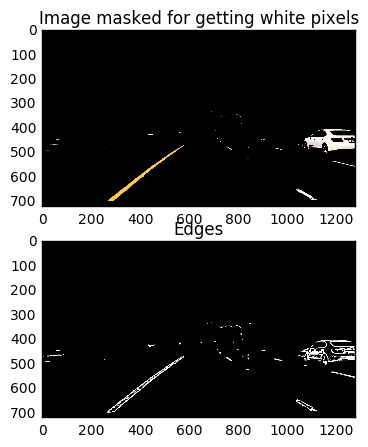

In [112]:
# Display interactive sliders
display.display(slider1, slider2, slider3, slider4, slider5, slider6)

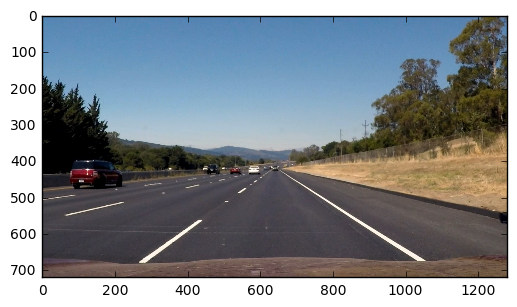

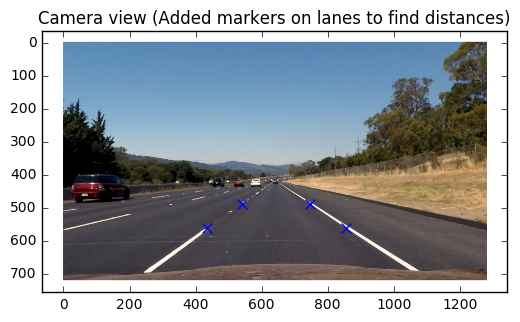


Transformation matrix: 
 [[ -5.94642857e-02  -3.55781250e-01   1.87026429e+02]
 [ -1.97758476e-16   1.59151786e-01  -9.58750000e+01]
 [ -3.02221356e-18  -2.38839286e-03   1.00000000e+00]]

Transformation matrix inverse: 
 [[ -1.68168168e+01  -2.18920452e+01   1.04628935e+03]
 [  1.17396372e-13  -1.43193895e+01  -1.37287147e+03]
 [  2.29564645e-16  -3.42003276e-02  -2.27895641e+00]]


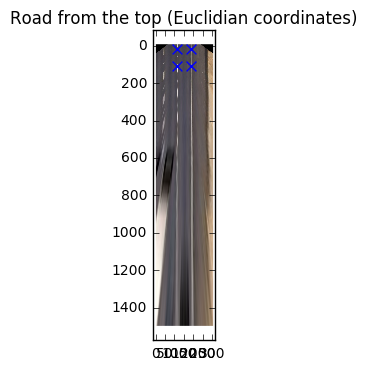

In [135]:
# Find PROJECTIVE transform for the road to find better masking region
# On an highway we could assume for this exercise (not safe in real car, just like masking with a 
# a triangle, that the lines should be fairly parallel to the direction of the vehicle.
# Minimum lane width: Minimum lane width of 12 feet (3.7 m)
# Each dashed line measures 10 feet (3.0 m), and the empty spaces in-between measure 30 feet (9.0m).


example_image = plt.imread('./test_images/straight_lines2.jpg')
plt.imshow(example_image)
plt.show()
img_undist = cal_undistort(example_image, objpoints, imgpoints)
plt.imshow(img_undist)

image_proj_work = img_undist.copy()
plt.imshow(image_proj_work)
plt.title('Camera view (Added markers on lanes to find distances)')

# Mark known points in image
points_px = np.float32( [ [436, 560], [540, 488],   [856, 560], [746, 488] ] )
plt.scatter(points_px[0][0], points_px[0][1], s=50, c='blue', marker='x')
plt.scatter(points_px[1][0], points_px[1][1], s=50, c='blue', marker='x')
plt.scatter(points_px[2][0], points_px[2][1], s=50, c='blue', marker='x')
plt.scatter(points_px[3][0], points_px[3][1], s=50, c='blue', marker='x')
plt.show()

# Points in meters
pt_distance_to_car = 2.0
dash_line_len = 9.0
lane_width = 3.7
center_of_car = 15
points_dest_px = np.float32( [ [center_of_car-lane_width, pt_distance_to_car],
                        [center_of_car-lane_width, pt_distance_to_car+dash_line_len],
                        [center_of_car+lane_width, pt_distance_to_car],
                        [center_of_car+lane_width, pt_distance_to_car+dash_line_len] ] )
meters_to_px = 10.0
points_m = meters_to_px * points_dest_px

transfM = cv2.getPerspectiveTransform(points_px,points_m)
print('\nTransformation matrix: \n', transfM)

transfMInv = np.linalg.inv(transfM)
print('\nTransformation matrix inverse: \n', transfMInv)

wrappedIm = cv2.warpPerspective(image_proj_work, transfM, (300,1500))


plt.imshow(wrappedIm)
plt.title('Road from the top (Euclidian coordinates)')

cv2.imwrite('foo.png',wrappedIm)

for line in range(points_px.shape[0]):
    points_dest_px2 = np.matmul(transfM, np.concatenate((points_px[line],[1]), axis=0)[np.newaxis].T)
    points_dest_px2 = points_dest_px2/points_dest_px2[2]
    plt.scatter(points_dest_px2[0], points_dest_px2[1], s=50, c='blue', marker='x')

plt.show()